<a href="https://colab.research.google.com/github/NickMcKillip/autodrive/blob/master/Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
 !curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
torchvision 0.2.1 has requirement pillow>=4.1.1, but you'll have pillow 4.0.0 which is incompatible.
tensorflow 1.13.1 has requirement tensorboard<1.14.0,>=1.13.0, but you'll have tensorboard 1.12.2 which is incompatible.
pymc3 3.6 has requirement joblib<0.13.0, but you'll have joblib 0.13.2 which is incompatible.
featuretools 0.4.1 has requirement pandas>=0.23.0, but you'll have pandas 0.22.0 which is incompatible.
albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.8 which is incompatible.
Done.


In [0]:
from fastai.vision import * 
from fastai.metrics import error_rate
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [3]:
bs = 16
path = untar_data(URLs.PETS)
path

PosixPath('/root/.fastai/data/oxford-iiit-pet')

In [4]:
path.ls()

[PosixPath('/root/.fastai/data/oxford-iiit-pet/annotations'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images')]

In [0]:
path_anno = path/'annotations'
path_img = path/'images'

In [6]:
fnames = get_image_files(path_img)
fnames[:5]

[PosixPath('/root/.fastai/data/oxford-iiit-pet/images/miniature_pinscher_61.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/staffordshire_bull_terrier_69.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/german_shorthaired_3.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/chihuahua_47.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/havanese_38.jpg')]

In [0]:
pat = r'/([^/]+)_\d+.jpg$'

In [0]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(), size=224, bs=bs
                                  ).normalize(imagenet_stats)

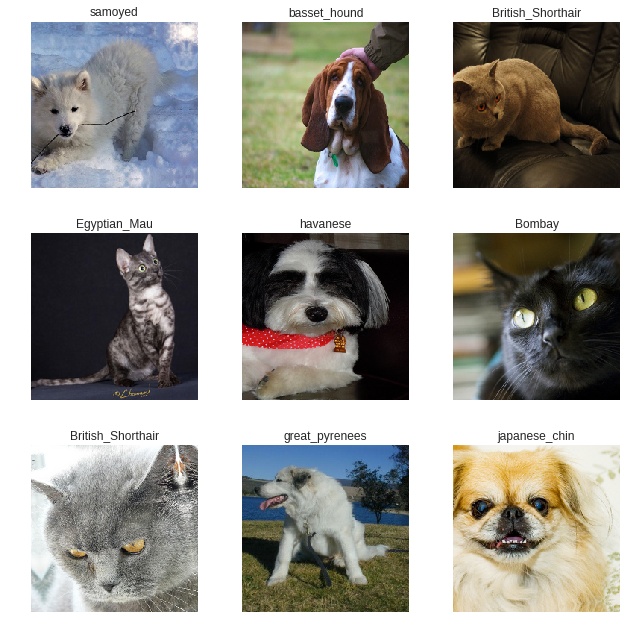

In [9]:
data.show_batch(rows=3,figsize=(9,9))

In [10]:
print(data.classes)

['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair', 'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue', 'Siamese', 'Sphynx', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'boxer', 'chihuahua', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'miniature_pinscher', 'newfoundland', 'pomeranian', 'pug', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']


In [11]:

learn = create_cnn(data, models.resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.torch/models/resnet34-333f7ec4.pth
87306240it [00:01, 76526860.90it/s]


In [12]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [0]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time


In [0]:
learn.lr_find()

In [0]:
learn.recorder.plot()

In [0]:
learn.unfreeze()
learn.fit_one_cycle(3, max_lr=slice(1e-6,1e-4))

# Image Segmentation

In [0]:

path = untar_data(URLs.CAMVID)
path.ls()

In [0]:
fnames = get_image_files(path_img)
fnames[:3]


In [0]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

In [0]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [0]:

get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [0]:
src_size = np.array(mask.shape[1:])
src_size,mask.data
codes = np.loadtxt(path/'codes.txt', dtype=str); codes

In [0]:
size = src_size//2

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=8
else:           bs=4
print(f"using bs={bs}, have {free}MB of GPU RAM free")

In [0]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn, classes=codes))

In [0]:
data_camvid = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

data_camvid.show_batch(2, figsize=(10,7))

In [0]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()
  

metrics=acc_camvid
# metrics=accuracy


In [0]:

wd=1e-2

learn = unet_learner(data_camvid, models.resnet34, metrics=metrics, wd=wd)

lr_find(learn)
learn.recorder.plot()


In [0]:
lr=3e-3

learn.fit_one_cycle(10, slice(lr), pct_start=0.9)



learn.save('stage-1')

learn.load('stage-1');



learn.show_results(rows=3, figsize=(8,9))


In [0]:
learn.unfreeze()

lrs = slice(lr/400,lr/4)


learn.fit_one_cycle(12, lrs, pct_start=0.8)


learn.save('stage-2')

learn.load('stage-2')

learn.show_results(rows=3,figsize=(8,9))

# Design your own NeuralNet layers

In [0]:
def conv(ni,nf): return nn.Conv2d(ni, nf, kernel_size=3, stride=2, padding=1)

In [0]:

model = nn.Sequential(
    conv(3, 8), # 14
    nn.BatchNorm2d(8),
    nn.ReLU(),
    conv(8, 16), # 7
    nn.BatchNorm2d(16),
    nn.ReLU(),
    conv(16, 32), # 4
    nn.BatchNorm2d(32),
    nn.ReLU(),
    conv(32, 16), # 2
    nn.BatchNorm2d(16),
    nn.ReLU(),
    conv(16, 10), # 1
    nn.BatchNorm2d(10),
    Flatten()     # remove (1,1) grid
)

In [0]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)
print(learn.summary())

In [0]:
#@title
learn.fit_one_cycle(4)

In [0]:

class ResBlock(nn.Module):
    def __init__(self, nf):
        super().__init__()
        self.conv1 = conv_layer(nf,nf)
        self.conv2 = conv_layer(nf,nf)
        
    def forward(self, x): return x + self.conv2(self.conv1(x))

In [0]:
model = nn.Sequential(
    conv_and_res(1, 8),
    conv_and_res(8, 16),
    conv_and_res(16, 32),
    conv_and_res(32, 16),
    conv2(16, 10),
    Flatten()
)
